## Parte 1. Construcción de una Serie de Tiempo. 
 

In [ ]:
#Se agregan las bibiliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Bibliotecas para el análisis de series de tiempo y modelos de pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

#Para suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#URL de los datos de un observatorio de la NASA en la Antartida
url = "https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt"

# Se nombran las columnas del df
my_cols = ['site_code', 'year', 'month', 'day', 'hour','minute','second','time_decimal', 'value', 'value_std_dev', 'nvalue', 'latitude','longitude','altitude', 'elevation', 'intake_height', 'qcflag']

# Se lee el dataframe
# El archivo tiene 151 líneas de encabezado, así que asignamos un dataframe que se salte dichas líneas
df_barrow = pd.read_csv(url, names=my_cols, encoding="cp1251", sep="\s+", header=None, skiprows=151, skipfooter=1, engine="python")

# Se realiza una copia con la que trabajar para no perder el original
df_c=df_barrow.copy()

# Reemplazamos los valores nulos iguales a -999.99 por 'NaN'
str_Nulo = -999.99
df_c = df_c.replace(to_replace=str_Nulo, value='NaN', regex=True)

# Se convierten los datos a valores numericos para poder trabajar con ellos
columnas = ["value"]
for cols in columnas:
  df_c[cols] = pd.to_numeric(df_c[cols], errors="coerce")


# Se asigna formato de fecha: (El .copy es necesario)
df_c["Fecha"] = pd.to_datetime(df_c["year"].astype(str) + df_c["month"].astype(str).str.zfill(2) + df_c["day"].astype(str).str.zfill(2),format="%Y%m%d").copy()

# Se agreaga la columna "Año"
df_c["Año"] = df_c["Fecha"].dt.year

# Se eliminan las columnas sig
df_c.drop(["year","month","day","hour","minute","second","time_decimal","site_code","value_std_dev","nvalue","latitude","longitude","altitude","elevation","intake_height","qcflag"], axis=1, inplace=True)

# Verificación
df_c

In [ ]:
# checkpoint
ts_test=df_c.copy()

# Se redefine el indice de todo el DataFrame para que sea la fecha en vez de un contador.
ts_test = ts_test.set_index("Fecha")

# Verificación
ts_test

In [ ]:
# La base de datos comienza desde 1975 al 2019, dado que el rango de interes a analizar son los últimos 30 años
# El rango de datos será: 1980 - 2019

# Se toman los datos de 1980 a 2019
ts_test = ts_test[(ts_test["Año"] >= 1980) & (ts_test["Año"] <= 2019)]

# Se elimina la columna "Año"
ts_test.drop(["Año"], axis=1, inplace=True)
ts_test.ffill(axis = 0, inplace=True)
ts_test

### Parte 2: Ánalisis de la serie de tiempo

In [ ]:
# Función para probar la estacionaridad de una serie de tiempo:
   
def test_stationarity(df_ts):
    
# Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() #std Desviación estándar
    
# Se define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

# Plot para graficar la estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Datos diarios')
    plt.plot(rolmean, color='red', label='Promedio Móvil 365 días')
    plt.plot(rolstd, color='black', label = 'Desviación Estándar del Prom Móvil')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
# Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

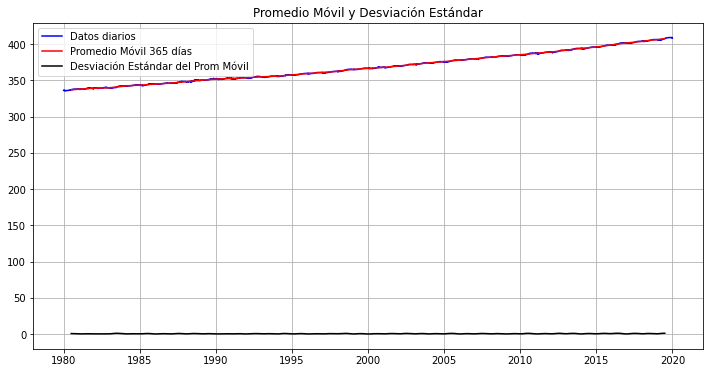

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     0.967299
p-value                            0.993909
#Lags Used                        42.000000
Number of Observations Used    14566.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [ ]:
# Se prueba la estacionaridad en la serie de tiempo "ts_test"
ts_test1 = ts_test["value"].copy()
test_stationarity(ts_test1)

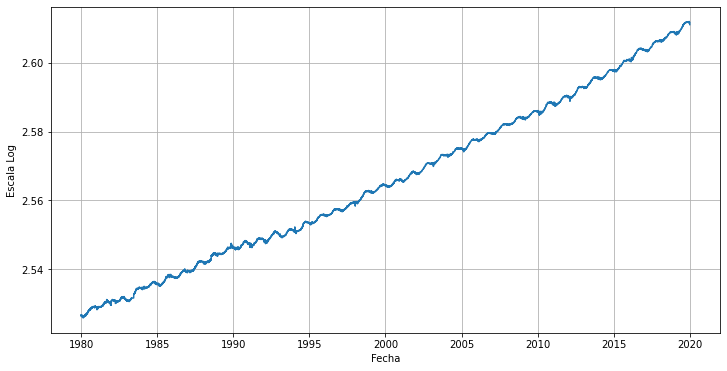

In [ ]:
#Debido a que según el valor p observamos que no es estacionaria, cambiamos a escala logaritmica.

ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log);
plt.grid()
plt.ylabel("Escala Log")
plt.xlabel("Fecha");

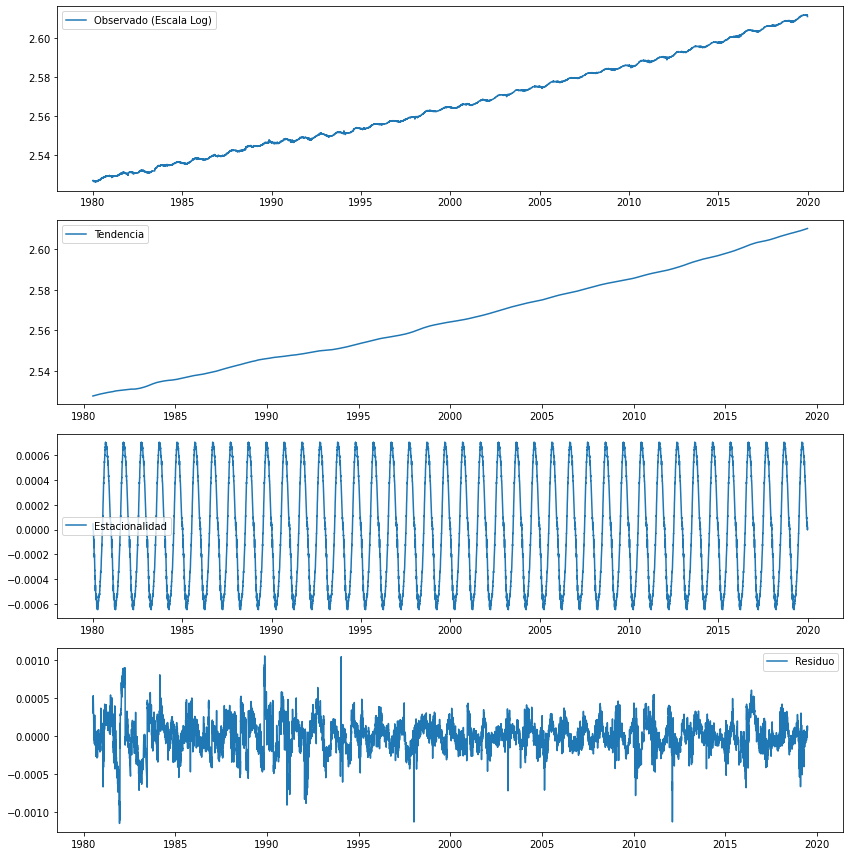

In [ ]:
# Se aplica el método de descomposición 

ts_test_log = np.log10(ts_test)

pmov = ts_test_log.rolling(365, center=True).mean()

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

# Serie de tendencia
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

# Serie de estacionalidad
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

# Serie de residuo
plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();


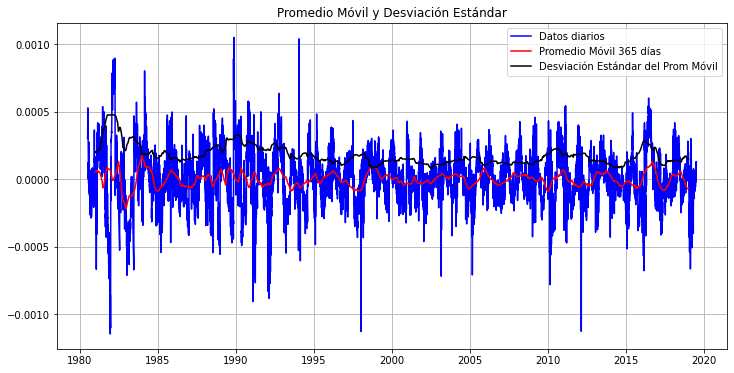

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135671e+01
p-value                        9.694298e-21
#Lags Used                     2.800000e+01
Number of Observations Used    1.421600e+04
Critical Value (1%)           -3.430810e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
# Quitamos los valores vacíos en la componente de residuo y probamos la estacionaridad de la componente de residuo

residue.dropna(inplace=True)
test_stationarity(residue['value'])

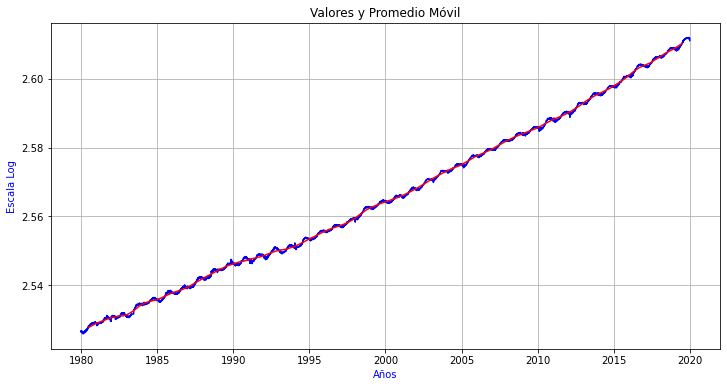

In [ ]:
# Se grafican los Promedios Moviles 
plt.plot(ts_test_log, color = 'b', label = 'ts_test_log')
plt.plot(pmov, color = 'r', label = 'Promedio móvil')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

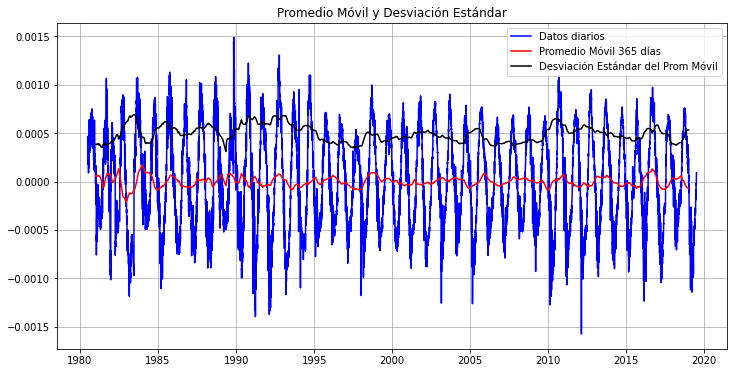

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135404e+01
p-value                        9.834028e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
# Dataframe para la prueba de estacionaridad para la diferencia entre la serie en log y el promedio
ts_test_log_diff = ts_test_log - pmov
# Quitamos valores nulos
ts_test_log_diff.dropna(inplace=True)
# Revisamos la estacionaridad de este nuevo dataframe
test_stationarity(ts_test_log_diff['value'])

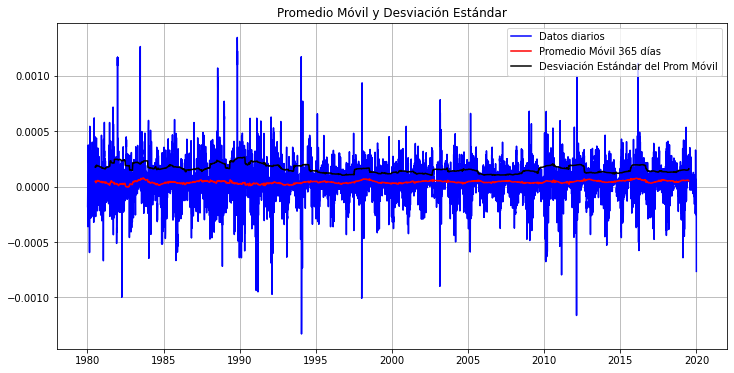

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.171116e+01
p-value                        1.487895e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.455900e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [ ]:
# Creamos otro dataframe similar pero con la función .shift con periodo de 7 días
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
# Quitamos valores nulos
ts_test_log_diff.dropna(inplace=True)
# Revisamos la estacionaridad 
test_stationarity(ts_test_log_diff['value'])

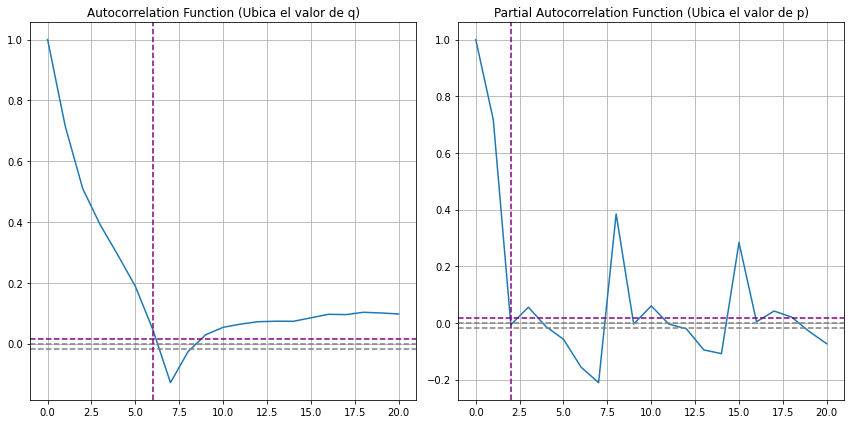

In [ ]:
#Se utilizan las funciones ACF y PACF para obtener los parametros de ARIMA(p y q)
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
#Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=6, linestyle='--', color='purple')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='purple')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(2, 1, 0)   Log Likelihood              116090.653
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232173.306
Time:                        21:24:33   BIC                        -232142.948
Sample:                    01-02-1980   HQIC                       -232163.220
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.785e-06   5.34e-07     10.835      0.000    4.74e-06    6.83e-06
ar.L1.D.value    -0.1516      0.008    -18.600      0.000      -0.168      -0.136
ar.L2.D.value    -0.1747      0.008    -

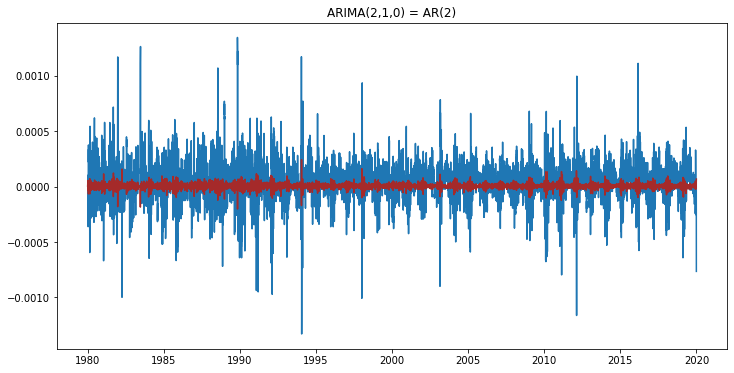

In [ ]:
#Aplicamos ARIMA
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(0, 1, 6)   Log Likelihood              116190.017
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232364.033
Time:                        21:24:54   BIC                        -232303.319
Sample:                    01-02-1980   HQIC                       -232343.863
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.791e-06   4.13e-07     14.024      0.000    4.98e-06     6.6e-06
ma.L1.D.value    -0.2070      0.008    -25.120      0.000      -0.223      -0.191
ma.L2.D.value    -0.1796      0.009    -

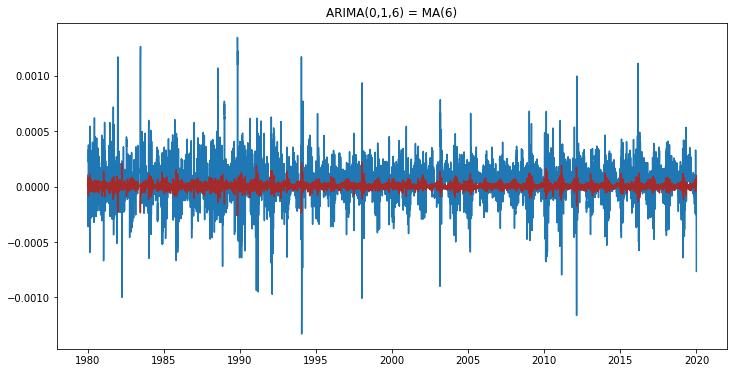

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,6) 
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(2, 1, 6)   Log Likelihood              116198.516
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232377.031
Time:                        21:25:40   BIC                        -232301.138
Sample:                    01-02-1980   HQIC                       -232351.818
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.794e-06   4.14e-07     14.001      0.000    4.98e-06    6.61e-06
ar.L1.D.value     0.3657        nan        nan        nan         nan         nan
ar.L2.D.value    -0.6900        nan     

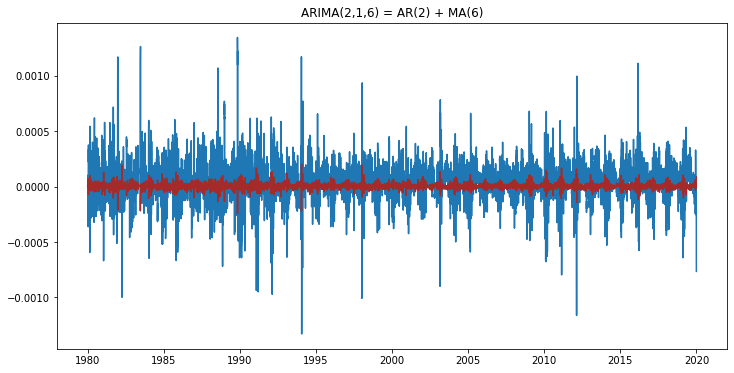

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

In [ ]:
# Creamos la serie de tiempo con los datos de las prediccións de ARIMA
ARIMA_ts = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_ts)

Fecha
1980-01-02    5.794445e-06
1980-01-03    9.896835e-06
1980-01-04    2.598721e-05
1980-01-05    3.229888e-05
1980-01-06    2.284285e-05
                  ...     
2019-12-26   -8.604927e-07
2019-12-27    4.886783e-06
2019-12-28    1.914988e-05
2019-12-29    3.297775e-05
2019-12-30    8.642108e-05
Length: 14608, dtype: float64


In [ ]:
# Sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
ARIMA_log = pd.Series(ts_test_log['value'], index = ts_test_log['value'].index)
ARIMA_log = ARIMA_log.add(ARIMA_ts)
print(ARIMA_log.head())
print(ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64
Fecha
2019-12-26    2.611850
2019-12-27    2.611792
2019-12-28    2.611742
2019-12-29    2.611438
2019-12-30    2.611183
dtype: float64


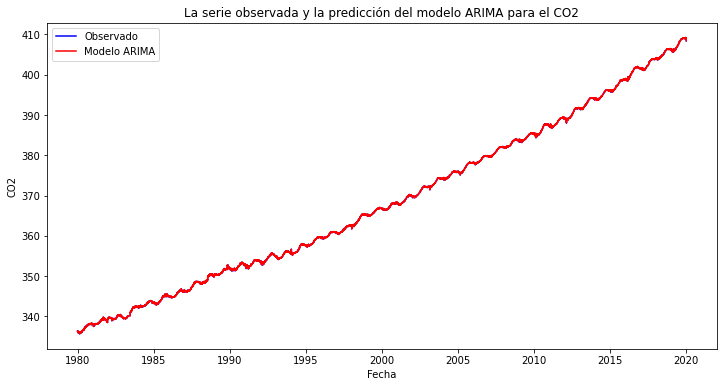

In [110]:
# Regresamos a la escala original
ARIMA_ts = 10**(ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test, label='Observado', color = 'b');
plt.plot(ARIMA_ts, label='Modelo ARIMA', color = 'r');
plt.xlabel('Fecha')
plt.ylabel('CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');

In [ ]:
# Se calcula el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((ARIMA_ts - ts_test['value'])**2))
print('RMSE:', RMSE)

RMSE: 0.018819871773235814


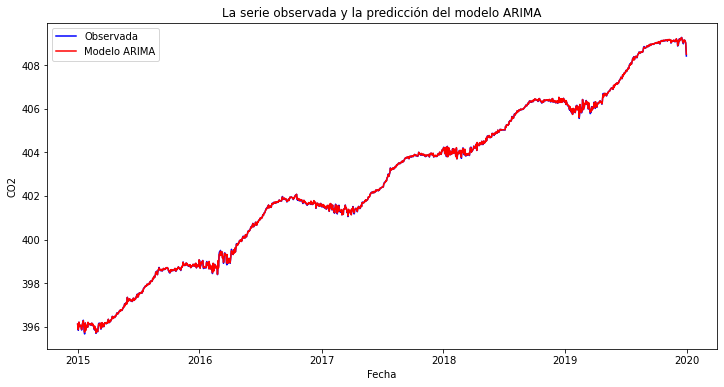

In [109]:
#Graficando los últimos 5 años de las series 
ts_test_last = ts_test.tail(1825)
ARIMA_ts_last = ARIMA_ts.tail(1825)
plt.plot(ts_test_last, label='Observada', color = 'b');
plt.plot(ARIMA_ts_last, label='Modelo ARIMA', color = 'r');
plt.xlabel('Fecha')
plt.ylabel('CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');